# Replicate: Nvidia AI IOT NanoSAM
### .onnx (cpu only)
July 29th

NanoSAM is a Segment Anything (SAM) model variant that is capable of running in 🔥 real-time 🔥 on NVIDIA Jetson Orin Platforms with NVIDIA TensorRT.

In [1]:
"""
# clean env wipe & activate
conda env remove --name mobilesam_py310 -y
conda create -n MobileSAM_onnx python=3.10 -y
conda activate MobileSAM_onnx

sudo apt update
sudo apt install libcudnn8 libcudnn8-dev
conda install -c conda-forge libstdcxx-ng=12 -y

"""

'\n# clean env wipe & activate\nconda env remove --name mobilesam_py310 -y\nconda create -n MobileSAM_onnx python=3.10 -y\nconda activate MobileSAM_onnx\n\nsudo apt update\nsudo apt install libcudnn8 libcudnn8-dev\nconda install -c conda-forge libstdcxx-ng=12 -y\n\n'

In [2]:
"""
# Instalation of MobileSAM repo requirements

pip install git+https://github.com/ChaoningZhang/MobileSAM.git

# pip install -r requirements.txt
# python setup.py install
pip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3 'opencv-python<4.9'


# typical np version mismatch
pip uninstall -y numpy
pip install "numpy>=1.19.2,<2.0"
# pip install numpy==1.26.4 

# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)
pip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl

# download torchvision 0.20.0a0 (compatible with jp61 torch)
cd ~/vision/
python3 setup.py install
cd ~

# Install ONNX runtime (REPO INSTRUCTIONS: We recommend to use onnx==1.12.0 onnxruntime==1.13.1 which is tested)
pip install onnx==1.12.0 onnxruntime==1.13.1

"""

# Debug Support

# Check your conda env GLIBCXX versions
# strings /home/copter/miniconda3/envs/nanosam_arm64/lib/python3.10/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6 | grep GLIBCXX

# trt2torch is apparently an issue and is obsolete for trt --version=10.3.0 
# additionally `pip install pycuda`

'\n# Instalation of MobileSAM repo requirements\n\npip install git+https://github.com/ChaoningZhang/MobileSAM.git\n\n# pip install -r requirements.txt\n# python setup.py install\npip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3 \'opencv-python<4.9\'\n\n\n# typical np version mismatch\npip uninstall -y numpy\npip install "numpy>=1.19.2,<2.0"\n# pip install numpy==1.26.4 \n\n# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)\npip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl\n\n# download torchvision 0.20.0a0 (compatible with jp61 torch)\ncd ~/vision/\npython3 setup.py install\ncd ~\n\n# Install ONNX runtime (REPO INSTRUCTIONS: We recommend to use onnx==1.12.0 onnxruntime==1.13.1 which is tested)\npip install onnx==1.12.0 onnxruntime==1.13.1\n\n'

In [3]:
# from nanosam.utils.predictor import Predictor
import onnxruntime as ort
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# 1) Create two ONNX Runtime sessions (will use CUDA if available)
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
enc_sess = ort.InferenceSession("/home/copter/onnx_models/nvidia_ai_iot_resnet18_image_encoder.onnx", providers=providers)
dec_sess = ort.InferenceSession("/home/copter/onnx_models/nvidia_ai_iot_mobile_sam_mask_decoder.onnx", providers=providers)


/home/copter/miniconda3/envs/nanosam_arm64/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(
2025-07-29 12:45:44.600242538 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 679499, index: 1, mask: {10, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-07-29 12:45:44.600309258 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 679500, index: 2, mask: {11, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-07-29 12:45:44.600439114 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 679498, index: 0, mask: {9, }, error code: 22 error msg: Invalid argumen

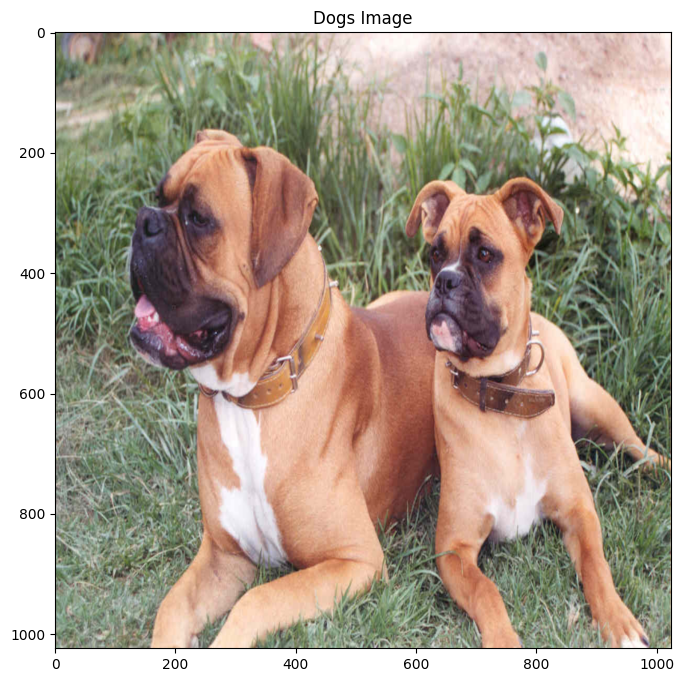

In [7]:

# Load the image
# image = PIL.open("/home/copter/jetson_benchmark/images/dogs.jpg")
image_path = "/home/copter/jetson_benchmark/images/dogs.jpg"
img = Image.open(image_path).convert("RGB")
img = img.resize((1024, 1024), resample=Image.BILINEAR)
w, h = img.size  # now both are 1024

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('on')  # Hide axes for cleaner display
plt.title("Dogs Image")
plt.show()

In [12]:
# 1) Inspect exactly which inputs the mask‐decoder wants:
for inp in dec_sess.get_inputs():
    print(inp.name, inp.shape, inp.type)


image_embeddings [1, 256, 64, 64] tensor(float)
point_coords [1, 'num_points', 2] tensor(float)
point_labels [1, 'num_points'] tensor(float)
mask_input [1, 1, 256, 256] tensor(float)
has_mask_input [1] tensor(float)


In [13]:
# 2) Normalize & transpose to NCHW
img_arr = np.array(img).astype(np.float32) / 255.0
input_image = img_arr.transpose(2, 0, 1)[None, :, :, :]

# 3) Run the encoder (H, W are supposed to be 1024 x 1024)
enc_input_name = enc_sess.get_inputs()[0].name
image_embeddings = enc_sess.run(None, {enc_input_name: input_image})[0]

In [14]:
# assume image_embeddings is already float32
# point_coords, point_labels — make them float32 as well
point_coords = np.array([[[w/2, h/2]]], dtype=np.float32)    # was already float32
point_labels = np.array([[1]],           dtype=np.float32)   # changed from int64

# dummy “previous mask” inputs must be float32
dummy_mask_input     = np.zeros((1, 1, 256, 256), dtype=np.float32)
dummy_has_mask_input = np.zeros((1,        ), dtype=np.float32)  # <— float32

# bundle by name
dec_input_names = [inp.name for inp in dec_sess.get_inputs()]
dec_inputs = {
    dec_input_names[0]: image_embeddings,
    dec_input_names[1]: point_coords,
    dec_input_names[2]: point_labels,
    dec_input_names[3]: dummy_mask_input,
    dec_input_names[4]: dummy_has_mask_input,
}

# unpack mask outputs
mask_out, scores = dec_sess.run(None, dec_inputs)


In [16]:
# ── Next cell ──
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1) Inspect the declared outputs to confirm ordering
print("Decoder outputs:")
for out in dec_sess.get_outputs():
    print(f"  {out.name}: {out.shape}")

# 2) Run and unpack correctly
raw_outs = dec_sess.run(None, dec_inputs)
# raw_outs[0].shape == (1, 4) → that's scores
# raw_outs[1].shape == (1, 4, 256, 256) → that's mask_out
scores, mask_out = raw_outs

# 3) Print shapes & count
print("mask_out shape:", mask_out.shape)   # should be (1, N, H, W)
print("scores   shape:", scores.shape)     # should be (1, N)
n_masks = mask_out.shape[1]
print("number of masks predicted:", n_masks)

# # 4) Flatten scores, pick best index
# scores_flat = scores.flatten()
# best_idx = int(np.argmax(scores_flat))
# print(f"Best mask index: {best_idx}  score: {scores_flat[best_idx]:.3f}")

# # 5) Extract & threshold the winning mask
# best_mask = mask_out[0, best_idx]              # (H,W) in [0,1]
# binary   = best_mask > 0.5
# mask_img = Image.fromarray((binary*255).astype(np.uint8))

# # 6) Resize mask back to original (w,h)
# mask_rs = mask_img.resize((w, h), Image.BILINEAR)

# # 7) Build a red overlay & composite
# red_ovl = Image.new("RGBA", (w, h), (255,0,0,0))
# red_ovl.putalpha(mask_rs)
# base    = img.convert("RGBA")
# comp    = Image.alpha_composite(base, red_ovl)

# # 8) Show it
# plt.figure(figsize=(6,6))
# plt.imshow(comp)
# plt.axis("off")


Decoder outputs:
  iou_predictions: ['Gemmiou_predictions_dim_0', 4]
  low_res_masks: ['Reshapelow_res_masks_dim_0', 'Reshapelow_res_masks_dim_1', 'Reshapelow_res_masks_dim_2', 'Reshapelow_res_masks_dim_3']
mask_out shape: (1, 4, 256, 256)
scores   shape: (1, 4)
number of masks predicted: 4


Best mask idx: 3   score: 1.008


(-0.5, 1023.5, 1023.5, -0.5)

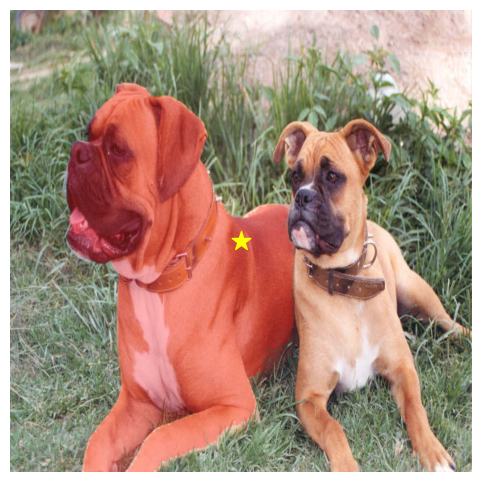

In [18]:
# 1) Pick the best mask
scores_flat = scores.flatten()
best_idx    = int(np.argmax(scores_flat))
print(f"Best mask idx: {best_idx}   score: {scores_flat[best_idx]:.3f}")

# 2) Extract, threshold, and resize the mask
raw_mask  = mask_out[0, best_idx]            # (H_mask,W_mask) in [0,1]
binary    = (raw_mask > 0.5).astype(np.uint8) * 255
mask_img  = Image.fromarray(binary)
mask_rs   = mask_img.resize((w, h), Image.BILINEAR)

# 3) Build a 20%‑opaque red overlay
#    Take the 0–255 mask and scale it to 0–51 (≈20% of 255)
alpha_mask = mask_rs.point(lambda p: int(p * 0.3))
red_layer  = Image.new("RGBA", (w, h), (255, 0, 0, 0))
red_layer.putalpha(alpha_mask)

# 4) Composite over the original
base_rgba  = img.convert("RGBA")
composited = Image.alpha_composite(base_rgba, red_layer)

# 5) Plot with a star at the prompt point
star_x, star_y = point_coords[0, 0]
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(composited)
ax.scatter(star_x, star_y, marker="*", color="yellow", s=200)
ax.axis("off")